<a href="https://colab.research.google.com/github/MrCuber/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition Project

## Contributors to this project:

<b>
<li>Umesh Chandra Sakinala - 21BCE1782
<li>Sujan Kumar Sollety - 21BCE5667
<li>Harshith Simha Gurram - 21BCE5653
<li>Pulipaka Phani Meghana - 21BCE1345
<li>Pandithradhyula Soumya - 21BCE1424
</b>

In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!touch ~/.kaggle/kaggle.json

In [ ]:
api_token = {"username":"umesh109","key":"aef50af22b6fe262935d024c7c135ac8"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import pandas as pd
import numpy as np

import kaggle

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Downloading Datasets

In [ ]:
!kaggle datasets download -d ejlok1/cremad

 96% 433M/451M [00:04<00:00, 54.1MB/s]
100% 451M/451M [00:04<00:00, 116MB/s] 


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 97% 417M/429M [00:03<00:00, 140MB/s]
100% 429M/429M [00:03<00:00, 141MB/s]
 90% 97.0M/107M [00:01<00:00, 92.0MB/s]
100% 107M/107M [00:01<00:00, 85.0MB/s] 
 97% 415M/428M [00:01<00:00, 253MB/s]
100% 428M/428M [00:01<00:00, 239MB/s]


### Unzip the datasets

In [ ]:
!unzip /content/cremad.zip
!unzip /content/ravdess-emotional-speech-audio.zip
!unzip /content/surrey-audiovisual-expressed-emotion-savee.zip

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1072_DFA_DIS_XX.wav  
  inflating: AudioWAV/1072_DFA_FEA_XX.wav  
  inflating: AudioWAV/1072_DFA_HAP_XX.wav  
  inflating: AudioWAV/1072_DFA_NEU_XX.wav  
  inflating: AudioWAV/1072_DFA_SAD_XX.wav  
  inflating: AudioWAV/1072_IEO_ANG_HI.wav  
  inflating: AudioWAV/1072_IEO_ANG_LO.wav  
  inflating: AudioWAV/1072_IEO_ANG_MD.wav  
  inflating: AudioWAV/1072_IEO_DIS_HI.wav  
  inflating: AudioWAV/1072_IEO_DIS_LO.wav  
  inflating: AudioWAV/1072_IEO_DIS_MD.wav  
  inflating: AudioWAV/1072_IEO_FEA_HI.wav  
  inflating: AudioWAV/1072_IEO_FEA_LO.wav  
  inflating: AudioWAV/1072_IEO_FEA_MD.wav  
  inflating: AudioWAV/1072_IEO_HAP_HI.wav  
  inflating: AudioWAV/1072_IEO_HAP_LO.wav  
  inflating: AudioWAV/1072_IEO_HAP_MD.wav  
  inflating: AudioWAV/1072_IEO_NEU_XX.wav  
  inflating: AudioWAV/1072_IEO_SAD_HI.wav  
  inflating: AudioWAV/1072_IEO_SAD_LO.wav  
  inflating: AudioWAV/1072_IEO_SAD_MD.wav  
  inflating: AudioWAV/107

In [ ]:
!unzip /content/toronto-emotional-speech-set-tess.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

### Paths for Datasets

In [ ]:
Ravdess = r"/content/audio_speech_actors_01-24"
Crema = r"/content/AudioWAV"
Tess = r"/content/TESS Toronto emotional speech set data"
Savee = r"/content/ALL"

## 1. Ravdess DataFrame

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess +'/'+ dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,calm,/content/audio_speech_actors_01-24/Actor_13/03...
1,sad,/content/audio_speech_actors_01-24/Actor_13/03...
2,disgust,/content/audio_speech_actors_01-24/Actor_13/03...
3,fear,/content/audio_speech_actors_01-24/Actor_13/03...
4,sad,/content/audio_speech_actors_01-24/Actor_13/03...


## 2. Crema DataFrame

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '\\' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,/content/AudioWAV\1034_IWW_ANG_XX.wav
1,happy,/content/AudioWAV\1068_TSI_HAP_XX.wav
2,happy,/content/AudioWAV\1047_IWW_HAP_XX.wav
3,sad,/content/AudioWAV\1048_ITS_SAD_XX.wav
4,sad,/content/AudioWAV\1006_IWL_SAD_XX.wav


##3. TESS dataset

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess +'/'+ dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,happy,/content/TESS Toronto emotional speech set dat...
1,happy,/content/TESS Toronto emotional speech set dat...
2,happy,/content/TESS Toronto emotional speech set dat...
3,happy,/content/TESS Toronto emotional speech set dat...
4,happy,/content/TESS Toronto emotional speech set dat...


##4. CREMA-D dataset

The audio files in this dataset are named in a way such that the prefix letters describes the emotion classes as the below:

<ul>
<li> 'a' = Anger
<li> 'd' = Disgust
<li> 'f' = Fear
<li> 'h' = Happiness
<li> 'n' = Neutral
<li> 'sa' = Sadness
<li> 'su' = Surprise
</ul>

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '\\' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,happy,/content/ALL\JE_h15.wav
1,surprise,/content/ALL\KL_su10.wav
2,disgust,/content/ALL\JE_d11.wav
3,neutral,/content/ALL\JK_n03.wav
4,neutral,/content/ALL\DC_n03.wav


In [ ]:
#creating combined dataframe
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path

,Emotions,Path
0,calm,/content/audio_speech_actors_01-24/Actor_13/03...
1,sad,/content/audio_speech_actors_01-24/Actor_13/03...
2,disgust,/content/audio_speech_actors_01-24/Actor_13/03...
3,fear,/content/audio_speech_actors_01-24/Actor_13/03...
4,sad,/content/audio_speech_actors_01-24/Actor_13/03...
...,...,...
1435,angry,/content/audio_speech_actors_01-24/Actor_23/03...
1436,sad,/content/audio_speech_actors_01-24/Actor_23/03...
1437,calm,/content/audio_speech_actors_01-24/Actor_23/03...
1438,angry,/content/audio_speech_actors_01-24/Actor_23/03...


## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

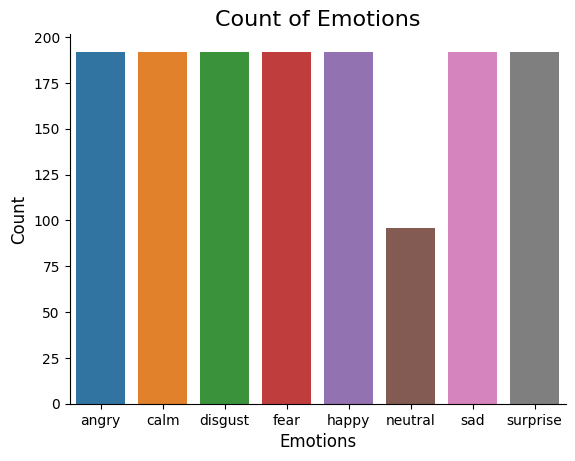

In [ ]:
data_path['Emotions'] = data_path['Emotions'].astype('category')

plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')  # Specify x parameter
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals
<li> Waveplots - Waveplots let us know the loudness of the audio at a given time
<li> Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It's a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Wave Plots for the Emotions

## <li>Fear

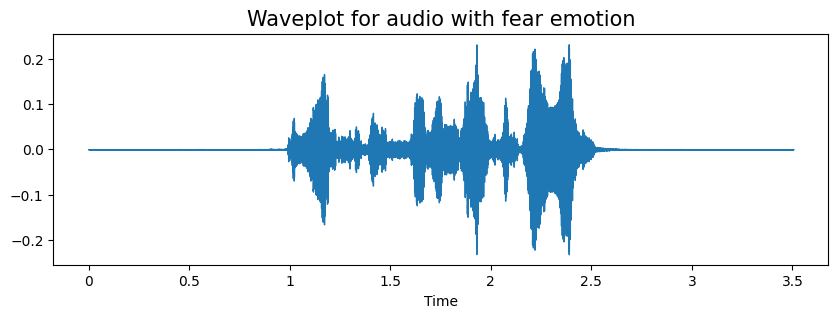

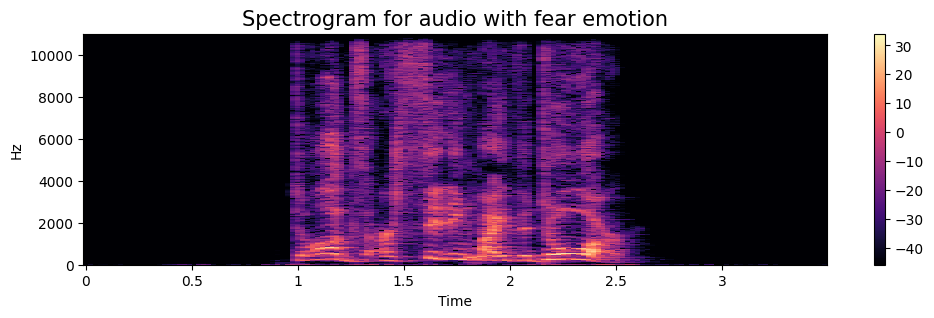

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Angry

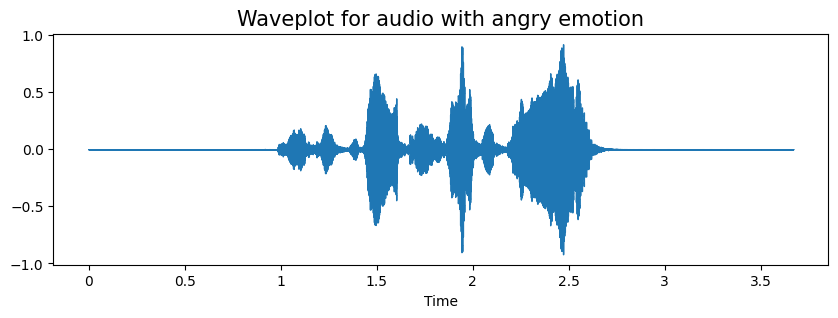

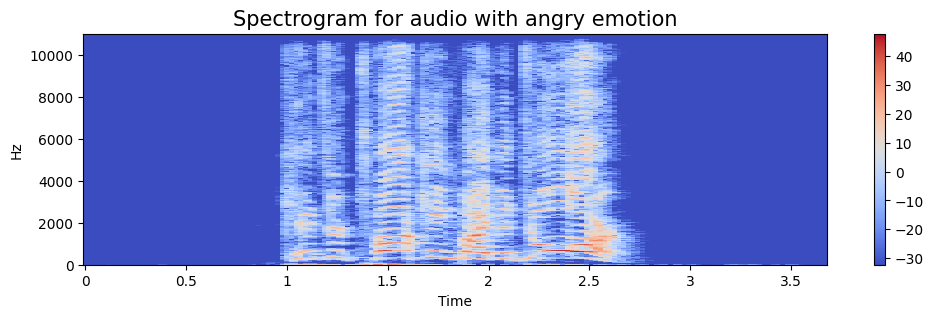

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Sad

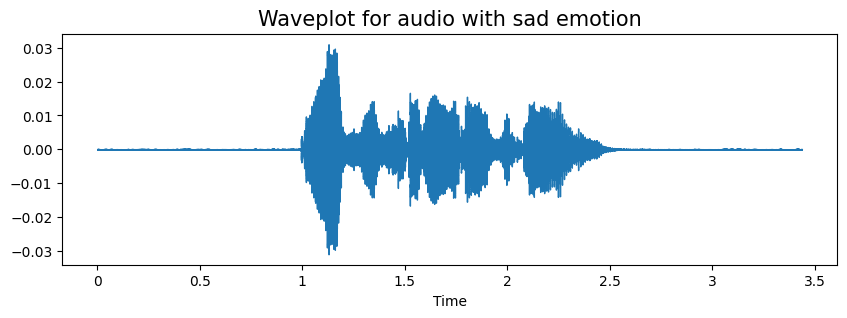

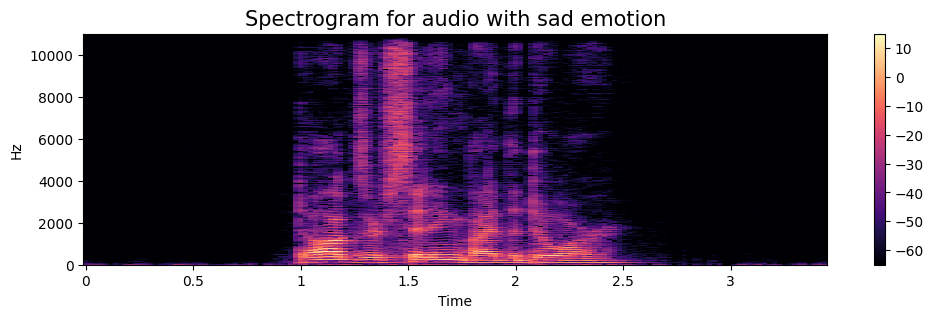

In [ ]:
emotion = 'sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## <li>Happy

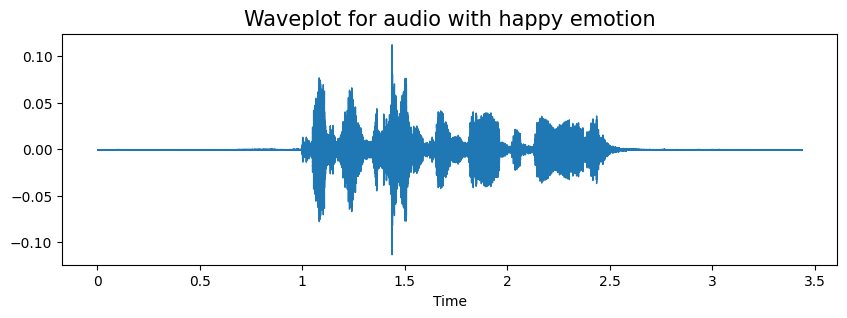

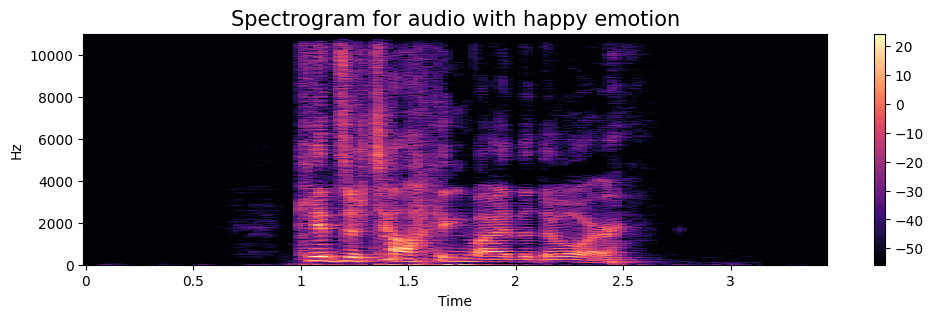

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation